## HyperParameter Tuned Feed Forward Neural Network Models

### Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
import html
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist, bigrams
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
import torch

# Load data
df = pd.read_csv('tweets.csv')
df.head()

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


### Data Preprocessing Functions

In [2]:
# Function to remove URLs
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

# Function to remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Function to remove HTML tags
def remove_html(text):
    html_tag = re.compile(r'<.*?>')
    return html_tag.sub(r'', text)

# Function to remove punctuation (including single and double quotes)
def remove_punct(text):
    return text.translate(str.maketrans('', '', string.punctuation + "“”’‘"))

# Function to remove HTML entities
def remove_html_entities(text):
    return html.unescape(text)

# Function to get POS tags in WordNet format
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

### Data Preprocessing Steps

In [3]:
# Applying preprocessing functions
df['text_clean'] = df['text'].apply(remove_URL)
df['text_clean'] = df['text_clean'].apply(remove_emoji)
df['text_clean'] = df['text_clean'].apply(remove_html)
df['text_clean'] = df['text_clean'].apply(remove_html_entities)
df['text_clean'] = df['text_clean'].apply(remove_punct)

# Tokenizing the clean text
df['tokenized'] = df['text_clean'].apply(word_tokenize)

# Lowercasing the tokenized text
df['lower'] = df['tokenized'].apply(lambda x: [word.lower() for word in x])

# Removing stopwords
stop = set(stopwords.words('english'))
df['stopwords_removed'] = df['lower'].apply(lambda x: [word for word in x if word not in stop])

# Applying part of speech tags
df['pos_tags'] = df['stopwords_removed'].apply(nltk.tag.pos_tag)

# Converting parts of speech to WordNet format
df['wordnet_pos'] = df['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

# Initialize the WordNet Lemmatizer
wnl = WordNetLemmatizer()

# Applying lemmatization using the WordNet POS tags
df['lemmatized'] = df['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x if tag is not None])

# Removing stopwords again from the lemmatized output
df['lemmatized'] = df['lemmatized'].apply(lambda x: [word for word in x if word not in stop])

# Concatenating the lemmatized words into a single string
df['final_text'] = df['lemmatized'].apply(' '.join)

df.head(10)

,id,keyword,location,text,target,text_clean,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos,lemmatized,final_text
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1,Communal violence in Bhainsa Telangana Stones ...,"[Communal, violence, in, Bhainsa, Telangana, S...","[communal, violence, in, bhainsa, telangana, s...","[communal, violence, bhainsa, telangana, stone...","[(communal, JJ), (violence, NN), (bhainsa, NN)...","[(communal, a), (violence, n), (bhainsa, n), (...","[communal, violence, bhainsa, telangana, stone...",communal violence bhainsa telangana stone pelt...
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1,Telangana Section 144 has been imposed in Bhai...,"[Telangana, Section, 144, has, been, imposed, ...","[telangana, section, 144, has, been, imposed, ...","[telangana, section, 144, imposed, bhainsa, ja...","[(telangana, JJ), (section, NN), (144, CD), (i...","[(telangana, a), (section, n), (144, None), (i...","[telangana, section, impose, bhainsa, january,...",telangana section impose bhainsa january clash...
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1,Arsonist sets cars ablaze at dealership,"[Arsonist, sets, cars, ablaze, at, dealership]","[arsonist, sets, cars, ablaze, at, dealership]","[arsonist, sets, cars, ablaze, dealership]","[(arsonist, JJ), (sets, NNS), (cars, NNS), (ab...","[(arsonist, a), (sets, n), (cars, n), (ablaze,...","[arsonist, set, car, ablaze, dealership]",arsonist set car ablaze dealership
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1,Arsonist sets cars ablaze at dealership,"[Arsonist, sets, cars, ablaze, at, dealership]","[arsonist, sets, cars, ablaze, at, dealership]","[arsonist, sets, cars, ablaze, dealership]","[(arsonist, JJ), (sets, NNS), (cars, NNS), (ab...","[(arsonist, a), (sets, n), (cars, n), (ablaze,...","[arsonist, set, car, ablaze, dealership]",arsonist set car ablaze dealership
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0,Lord Jesus your love brings freedom and pardon...,"[Lord, Jesus, your, love, brings, freedom, and...","[lord, jesus, your, love, brings, freedom, and...","[lord, jesus, love, brings, freedom, pardon, f...","[(lord, NN), (jesus, NN), (love, VBP), (brings...","[(lord, n), (jesus, n), (love, v), (brings, n)...","[lord, jesus, love, brings, freedom, pardon, f...",lord jesus love brings freedom pardon fill hol...
5,5,ablaze,OC,"If this child was Chinese, this tweet would ha...",0,If this child was Chinese this tweet would hav...,"[If, this, child, was, Chinese, this, tweet, w...","[if, this, child, was, chinese, this, tweet, w...","[child, chinese, tweet, would, gone, viral, so...","[(child, NN), (chinese, JJ), (tweet, NN), (wou...","[(child, n), (chinese, a), (tweet, n), (would,...","[child, chinese, tweet, go, viral, social, med...",child chinese tweet go viral social medium abl...
6,6,ablaze,"London, England",Several houses have been set ablaze in Ngemsib...,1,Several houses have been set ablaze in Ngemsib...,"[Several, houses, have, been, set, ablaze, in,...","[several, houses, have, been, set, ablaze, in,...","[several, houses, set, ablaze, ngemsibaa, vill...","[(several, JJ), (houses, NNS), (set, VBD), (ab...","[(several, a), (houses, n), (set, v), (ablaze,...","[several, house, set, ablaze, ngemsibaa, villa...",several house set ablaze ngemsibaa village oku...
7,7,ablaze,Bharat,Asansol: A BJP office in Salanpur village was ...,1,Asansol A BJP office in Salanpur village was s...,"[Asansol, A, BJP, office, in, Salanpur, villag...","[asansol, a, bjp, office, in, salanpur, villag...","[asansol, bjp, office, salanpur, village, set,...","[(asansol, NNS), (bjp, JJ), (office, NN), (sal...","[(asansol, n), (bjp, a), (office, n), (salanpu...","[asansol, bjp, office, salanpur, village, set,...",asansol bjp office salanpur village set ablaze...
8,8,ablaze,"Accra, Ghana","National Security Minister, Kan Dapaah's side ...",0,National Secur

### Splitting the Data to Avoid Data Leakage

In [4]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['final_text'], df['target'], test_size=0.2, random_state=42)

# Ensure y_train and y_test are numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

# Check unique values in y_train
unique_classes = np.unique(y_train)
print("Unique classes in y_train:", unique_classes)

# Compute class weights correctly
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train)
class_weights_dict = dict(zip(unique_classes, class_weights))
print("Updated class weights dict:", class_weights_dict)

Unique classes in y_train: [0 1]
Updated class weights dict: {0: 0.6164272160477094, 1: 2.647264260768335}


### Vectorisation (TF-IDF, CountVectorizer, Word2Vec, BERT)

In [5]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# CountVectorizer
count_vectorizer = CountVectorizer()
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

# Word2Vec Vectorization
sentences = [text.split() for text in X_train]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
word2vec_model.train(sentences, total_examples=len(sentences), epochs=10)

def get_word2vec_embeddings(text, model, vector_size):
    words = text.split()
    embedding = np.zeros(vector_size)
    count = 0
    for word in words:
        if word in model.wv.key_to_index:
            embedding += model.wv[word]
            count += 1
    if count > 0:
        embedding /= count
    return embedding

X_train_word2vec = np.array([get_word2vec_embeddings(text, word2vec_model, 100) for text in X_train])
X_test_word2vec = np.array([get_word2vec_embeddings(text, word2vec_model, 100) for text in X_test])

# BERT Embeddings
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

X_train_bert = np.array([get_bert_embeddings(text, tokenizer, model) for text in X_train])
X_test_bert = np.array([get_bert_embeddings(text, tokenizer, model) for text in X_test])

# Ensure you have the correct shapes
print(X_train_tfidf.shape, X_train_count.shape, X_train_word2vec.shape, X_train_bert.shape)

(9096, 16569) (9096, 16569) (9096, 100) (9096, 768)


### Feed forward Neural Network(FFNN) Model Building and Training

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Metric
from scikeras.wrappers import KerasClassifier

class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)
    
    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    
    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

def create_ffnn(neurons, activation, optimizer, dropout, input_shape):
    model = Sequential()
    model.add(Dense(neurons, input_shape=(input_shape,), activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(64, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))  # For binary classification
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[F1Score()])
    return model

### Hyperparameter Tuning Using GridSearchCV

In [7]:
param_grid = {
    'batch_size': [16, 32],
    'epochs': [10, 20],
    'model__neurons': [64, 128],
    'model__activation': ['relu', 'tanh'],
    'model__optimizer': ['adam', 'rmsprop'],
    'model__dropout': [0.1, 0.2]
}

# TF-IDF Model Tuning
input_shape = X_train_tfidf.shape[1]
model = KerasClassifier(
    model=create_ffnn,
    neurons=64, activation='relu', optimizer='adam', dropout=0.1, input_shape=input_shape,
    verbose=0
)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring='f1')
grid_result = grid.fit(X_train_tfidf.toarray(), y_train, class_weight=class_weights_dict)
best_params_tfidf = grid_result.best_params_

model_tfidf_tuned = create_ffnn(
    neurons=best_params_tfidf['model__neurons'],
    activation=best_params_tfidf['model__activation'],
    optimizer=best_params_tfidf['model__optimizer'],
    dropout=best_params_tfidf['model__dropout'],
    input_shape=input_shape
)
history_tfidf = model_tfidf_tuned.fit(
    X_train_tfidf.toarray(), y_train,
    epochs=best_params_tfidf['epochs'],
    batch_size=best_params_tfidf['batch_size'],
    validation_data=(X_test_tfidf.toarray(), y_test),
    class_weight=class_weights_dict,
    callbacks=[EarlyStopping(patience=3)]
)

C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
569/569 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - f1_score: 0.2671 - loss: 0.6596 - val_f1_score: 0.5238 - val_loss: 0.4444
Epoch 2/20
569/569 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - f1_score: 0.6055 - loss: 0.4625 - val_f1_score: 0.5763 - val_loss: 0.3926
Epoch 3/20
569/569 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - f1_score: 0.6715 - loss: 0.3968 - val_f1_score: 0.5942 - val_loss: 0.3968
Epoch 4/20
569/569 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - f1_score: 0.7419 - loss: 0.3300 - val_f1_score: 0.6232 - val_loss: 0.3914
Epoch 5/20
569/569 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - f1_score: 0.7980 - loss: 0.2846 - val_f1_score: 0.6240 - val_loss: 0.4175
Epoch 6/20
569/569 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - f1_score: 0.8446 - loss: 0.2566 - val_f1_score: 0.6266 - val_loss: 0.4256
Epoch 7/20
569/569 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - f1_score: 0.8744 - loss: 0.2417 - val_f1_score: 0.6361 - val_loss: 0.4153


In [8]:
# CountVectorizer Model Tuning
input_shape = X_train_count.shape[1]
model = KerasClassifier(
    model=create_ffnn,
    neurons=64, activation='relu', optimizer='adam', dropout=0.1, input_shape=input_shape,
    verbose=0
)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring='f1')
grid_result = grid.fit(X_train_count.toarray(), y_train, class_weight=class_weights_dict)
best_params_count = grid_result.best_params_

model_count_tuned = create_ffnn(
    neurons=best_params_count['model__neurons'],
    activation=best_params_count['model__activation'],
    optimizer=best_params_count['model__optimizer'],
    dropout=best_params_count['model__dropout'],
    input_shape=input_shape
)
history_count = model_count_tuned.fit(
    X_train_count.toarray(), y_train,
    epochs=best_params_count['epochs'],
    batch_size=best_params_count['batch_size'],
    validation_data=(X_test_count.toarray(), y_test),
    class_weight=class_weights_dict,
    callbacks=[EarlyStopping(patience=3)]
)

C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - f1_score: 0.3641 - loss: 0.6232 - val_f1_score: 0.5326 - val_loss: 0.4867
Epoch 2/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - f1_score: 0.6605 - loss: 0.4028 - val_f1_score: 0.6042 - val_loss: 0.4200
Epoch 3/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - f1_score: 0.7993 - loss: 0.3158 - val_f1_score: 0.6344 - val_loss: 0.4519
Epoch 4/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - f1_score: 0.8751 - loss: 0.2318 - val_f1_score: 0.6807 - val_loss: 0.3795
Epoch 5/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - f1_score: 0.9101 - loss: 0.2028 - val_f1_score: 0.6770 - val_loss: 0.4125
Epoch 6/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - f1_score: 0.9275 - loss: 0.1680 - val_f1_score: 0.6893 - val_loss: 0.3763
Epoch 7/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - f1_score: 0.9414 - loss: 0.1430 - val_f1_score: 0.6863 - val_loss: 0.4420
Epoch 8/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - f1_score: 0.9571 - loss: 0.1053 - val_f1_score: 0.

In [9]:
# Word2Vec Model Tuning
input_shape = X_train_word2vec.shape[1]
model = KerasClassifier(
    model=create_ffnn,
    neurons=64, activation='relu', optimizer='adam', dropout=0.1, input_shape=input_shape,
    verbose=0
)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring='f1')
grid_result = grid.fit(X_train_word2vec, y_train, class_weight=class_weights_dict)
best_params_word2vec = grid_result.best_params_

model_word2vec_tuned = create_ffnn(
    neurons=best_params_word2vec['model__neurons'],
    activation=best_params_word2vec['model__activation'],
    optimizer=best_params_word2vec['model__optimizer'],
    dropout=best_params_word2vec['model__dropout'],
    input_shape=input_shape
)
history_word2vec = model_word2vec_tuned.fit(
    X_train_word2vec, y_train,
    epochs=best_params_word2vec['epochs'],
    batch_size=best_params_word2vec['batch_size'],
    validation_data=(X_test_word2vec, y_test),
    class_weight=class_weights_dict,
    callbacks=[EarlyStopping(patience=3)]
)

C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - f1_score: 0.3908 - loss: 0.6357 - val_f1_score: 0.5112 - val_loss: 0.5020
Epoch 2/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - f1_score: 0.4846 - loss: 0.5606 - val_f1_score: 0.4609 - val_loss: 0.6288
Epoch 3/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - f1_score: 0.4945 - loss: 0.5569 - val_f1_score: 0.5042 - val_loss: 0.4795
Epoch 4/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - f1_score: 0.5061 - loss: 0.5531 - val_f1_score: 0.5024 - val_loss: 0.5065
Epoch 5/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - f1_score: 0.5089 - loss: 0.5455 - val_f1_score: 0.4489 - val_loss: 0.6872
Epoch 6/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - f1_score: 0.5023 - loss: 0.5518 - val_f1_score: 0.4692 - val_loss: 0.5664


In [10]:
# BERT Model Tuning
input_shape = X_train_bert.shape[1]
model = KerasClassifier(
    model=create_ffnn,
    neurons=64, activation='relu', optimizer='adam', dropout=0.1, input_shape=input_shape,
    verbose=0
)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring='f1')
grid_result = grid.fit(X_train_bert, y_train, class_weight=class_weights_dict)
best_params_bert = grid_result.best_params_

model_bert_tuned = create_ffnn(
    neurons=best_params_bert['model__neurons'],
    activation=best_params_bert['model__activation'],
    optimizer=best_params_bert['model__optimizer'],
    dropout=best_params_bert['model__dropout'],
    input_shape=input_shape
)
history_bert = model_bert_tuned.fit(
    X_train_bert, y_train,
    epochs=best_params_bert['epochs'],
    batch_size=best_params_bert['batch_size'],
    validation_data=(X_test_bert, y_test),
    class_weight=class_weights_dict,
    callbacks=[EarlyStopping(patience=3)]
)

C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


C:\Users\Aravinthkumar\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


569/569 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - f1_score: 0.5261 - loss: 0.5161 - val_f1_score: 0.6192 - val_loss: 0.3790
Epoch 2/20
569/569 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_score: 0.6211 - loss: 0.4129 - val_f1_score: 0.5992 - val_loss: 0.4011
Epoch 3/20
569/569 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_score: 0.6300 - loss: 0.3926 - val_f1_score: 0.6176 - val_loss: 0.4184
Epoch 4/20
569/569 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - f1_score: 0.6498 - loss: 0.3724 - val_f1_score: 0.5959 - val_loss: 0.4191


### Evaluate Models and Compile Metrics

In [11]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

# Function to calculate evaluation metrics
def evaluate_model(model, X_test, y_test):
    y_pred_prob = model.predict(X_test).ravel()
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

# Initialize a dictionary to store the metrics for each model
metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

# Evaluate the tuned models
tuned_metrics_tfidf = evaluate_model(model_tfidf_tuned, X_test_tfidf.toarray(), y_test)
tuned_metrics_count = evaluate_model(model_count_tuned, X_test_count.toarray(), y_test)
tuned_metrics_word2vec = evaluate_model(model_word2vec_tuned, X_test_word2vec, y_test)
tuned_metrics_bert = evaluate_model(model_bert_tuned, X_test_bert, y_test)

# Add the tuned metrics to the DataFrame
metrics['Model'].append('Tuned TF-IDF')
for metric, value in tuned_metrics_tfidf.items():
    metrics[metric].append(value)

metrics['Model'].append('Tuned Count Vectorisation')
for metric, value in tuned_metrics_count.items():
    metrics[metric].append(value)

metrics['Model'].append('Tuned Word2Vec')
for metric, value in tuned_metrics_word2vec.items():
    metrics[metric].append(value)

metrics['Model'].append('Tuned BERT')
for metric, value in tuned_metrics_bert.items():
    metrics[metric].append(value)

# Create an updated DataFrame with the new results
metrics_df_updated = pd.DataFrame(metrics)
metrics_df_updated

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


,Model,Accuracy,Precision,Recall,F1-Score
0,Tuned TF-IDF,0.857080,0.571429,0.717172,0.636058
1,Tuned Count Vectorisation,0.890501,0.673759,0.719697,0.695971
2,Tuned Word2Vec,0.712401,0.345694,0.729798,0.469156
3,Tuned BERT,0.800792,0.460690,0.843434,0.595897


### Plotting the Model Performance

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step


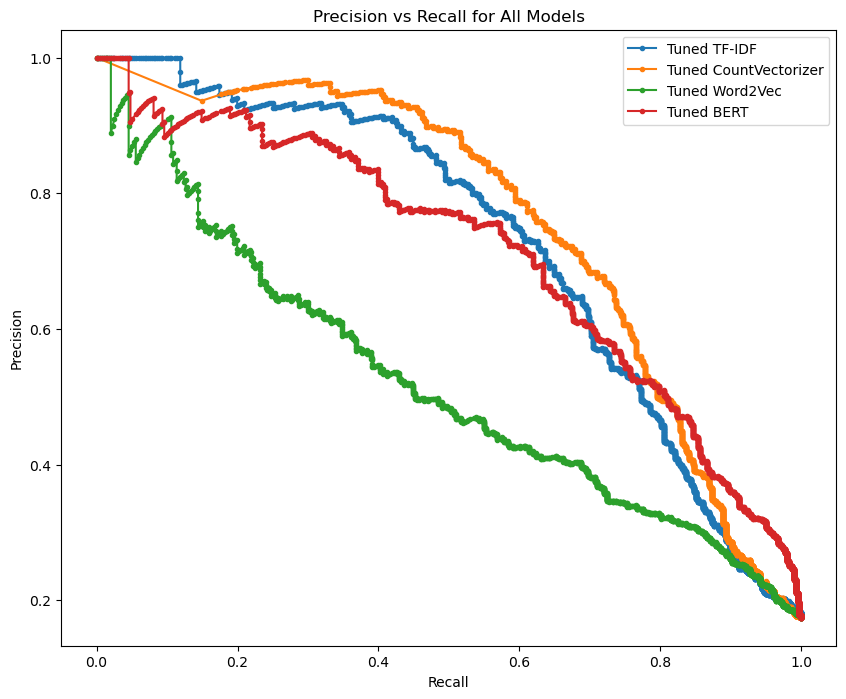

In [23]:
from sklearn.metrics import precision_recall_curve

# Plotting Precision vs Recall for all models in a single plot
plt.figure(figsize=(10, 8))

# TF-IDF
y_pred_prob_tfidf = model_tfidf_tuned.predict(X_test_tfidf.toarray()).ravel()
precision_tfidf, recall_tfidf, _ = precision_recall_curve(y_test, y_pred_prob_tfidf)
plt.plot(recall_tfidf, precision_tfidf, marker='.', label='Tuned TF-IDF')

# CountVectorizer
y_pred_prob_count = model_count_tuned.predict(X_test_count.toarray()).ravel()
precision_count, recall_count, _ = precision_recall_curve(y_test, y_pred_prob_count)
plt.plot(recall_count, precision_count, marker='.', label='Tuned CountVectorizer')

# Word2Vec
y_pred_prob_word2vec = model_word2vec_tuned.predict(X_test_word2vec).ravel()
precision_word2vec, recall_word2vec, _ = precision_recall_curve(y_test, y_pred_prob_word2vec)
plt.plot(recall_word2vec, precision_word2vec, marker='.', label='Tuned Word2Vec')

# BERT
y_pred_prob_bert = model_bert_tuned.predict(X_test_bert).ravel()
precision_bert, recall_bert, _ = precision_recall_curve(y_test, y_pred_prob_bert)
plt.plot(recall_bert, precision_bert, marker='.', label='Tuned BERT')

plt.title('Precision vs Recall for All Models')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

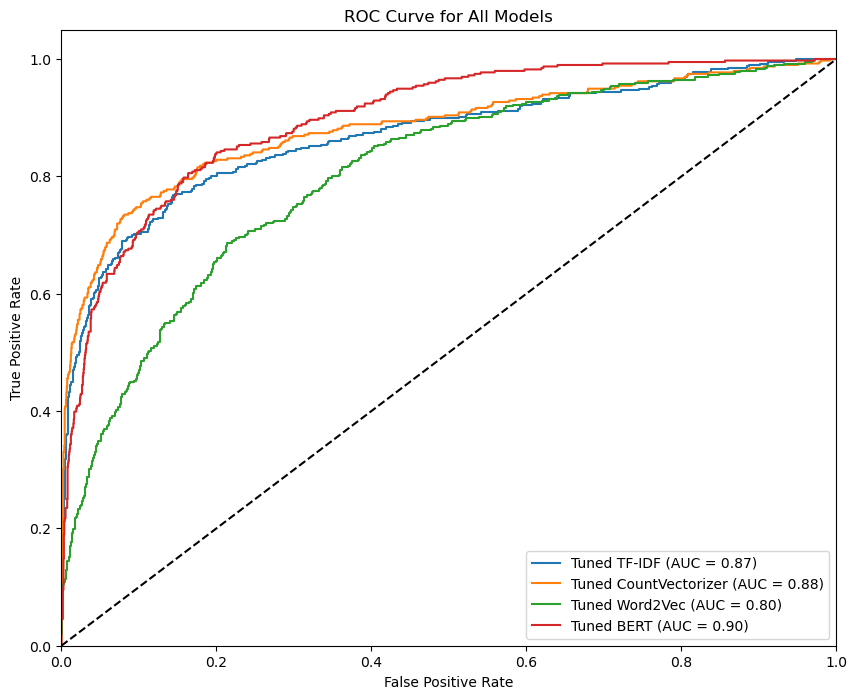

In [25]:
from sklearn.metrics import roc_curve, auc

# Plotting ROC curve for all models in a single plot
plt.figure(figsize=(10, 8))

# TF-IDF
fpr_tfidf, tpr_tfidf, _ = roc_curve(y_test, y_pred_prob_tfidf)
roc_auc_tfidf = auc(fpr_tfidf, tpr_tfidf)
plt.plot(fpr_tfidf, tpr_tfidf, label=f'Tuned TF-IDF (AUC = {roc_auc_tfidf:.2f})')

# CountVectorizer
fpr_count, tpr_count, _ = roc_curve(y_test, y_pred_prob_count)
roc_auc_count = auc(fpr_count, tpr_count)
plt.plot(fpr_count, tpr_count, label=f'Tuned CountVectorizer (AUC = {roc_auc_count:.2f})')

# Word2Vec
fpr_word2vec, tpr_word2vec, _ = roc_curve(y_test, y_pred_prob_word2vec)
roc_auc_word2vec = auc(fpr_word2vec, tpr_word2vec)
plt.plot(fpr_word2vec, tpr_word2vec, label=f'Tuned Word2Vec (AUC = {roc_auc_word2vec:.2f})')

# BERT
fpr_bert, tpr_bert, _ = roc_curve(y_test, y_pred_prob_bert)
roc_auc_bert = auc(fpr_bert, tpr_bert)
plt.plot(fpr_bert, tpr_bert, label=f'Tuned BERT (AUC = {roc_auc_bert:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC Curve for All Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

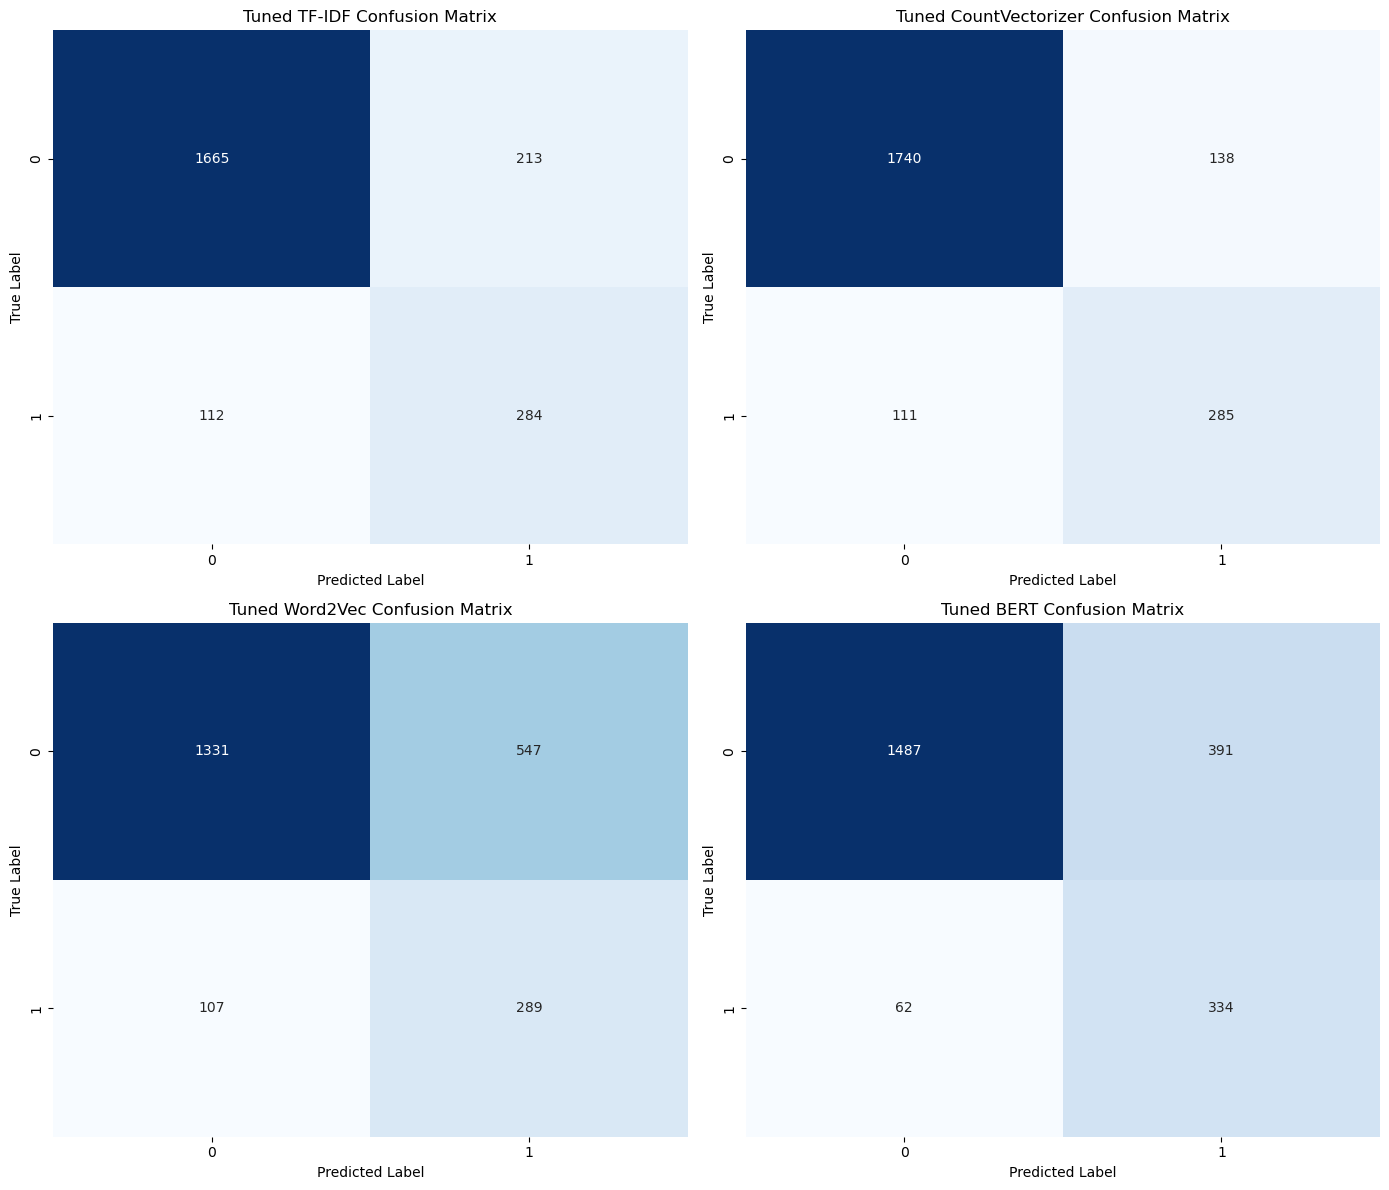

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create subplots for confusion matrices
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# TF-IDF Confusion Matrix
y_pred_tfidf = (y_pred_prob_tfidf > 0.5).astype(int)
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[0, 0])
axs[0, 0].set_title('Tuned TF-IDF Confusion Matrix')
axs[0, 0].set_xlabel('Predicted Label')
axs[0, 0].set_ylabel('True Label')

# CountVectorizer Confusion Matrix
y_pred_count = (y_pred_prob_count > 0.5).astype(int)
cm_count = confusion_matrix(y_test, y_pred_count)
sns.heatmap(cm_count, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[0, 1])
axs[0, 1].set_title('Tuned CountVectorizer Confusion Matrix')
axs[0, 1].set_xlabel('Predicted Label')
axs[0, 1].set_ylabel('True Label')

# Word2Vec Confusion Matrix
y_pred_word2vec = (y_pred_prob_word2vec > 0.5).astype(int)
cm_word2vec = confusion_matrix(y_test, y_pred_word2vec)
sns.heatmap(cm_word2vec, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[1, 0])
axs[1, 0].set_title('Tuned Word2Vec Confusion Matrix')
axs[1, 0].set_xlabel('Predicted Label')
axs[1, 0].set_ylabel('True Label')

# BERT Confusion Matrix
y_pred_bert = (y_pred_prob_bert > 0.5).astype(int)
cm_bert = confusion_matrix(y_test, y_pred_bert)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[1, 1])
axs[1, 1].set_title('Tuned BERT Confusion Matrix')
axs[1, 1].set_xlabel('Predicted Label')
axs[1, 1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

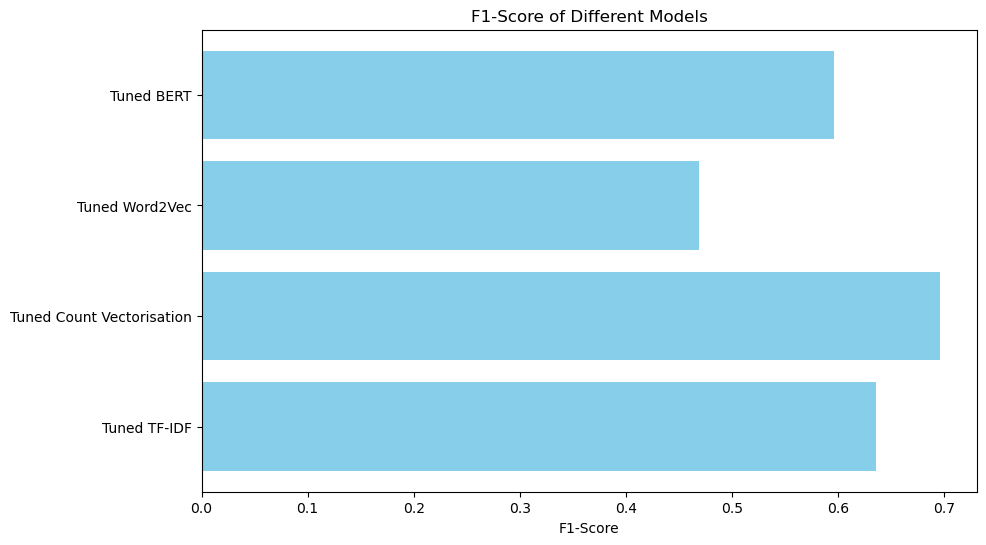

In [12]:
# Plotting F1-Score for each model
plt.figure(figsize=(10, 6))
plt.barh(metrics_df_updated['Model'], metrics_df_updated['F1-Score'], color='skyblue')
plt.xlabel('F1-Score')
plt.title('F1-Score of Different Models')
plt.show()

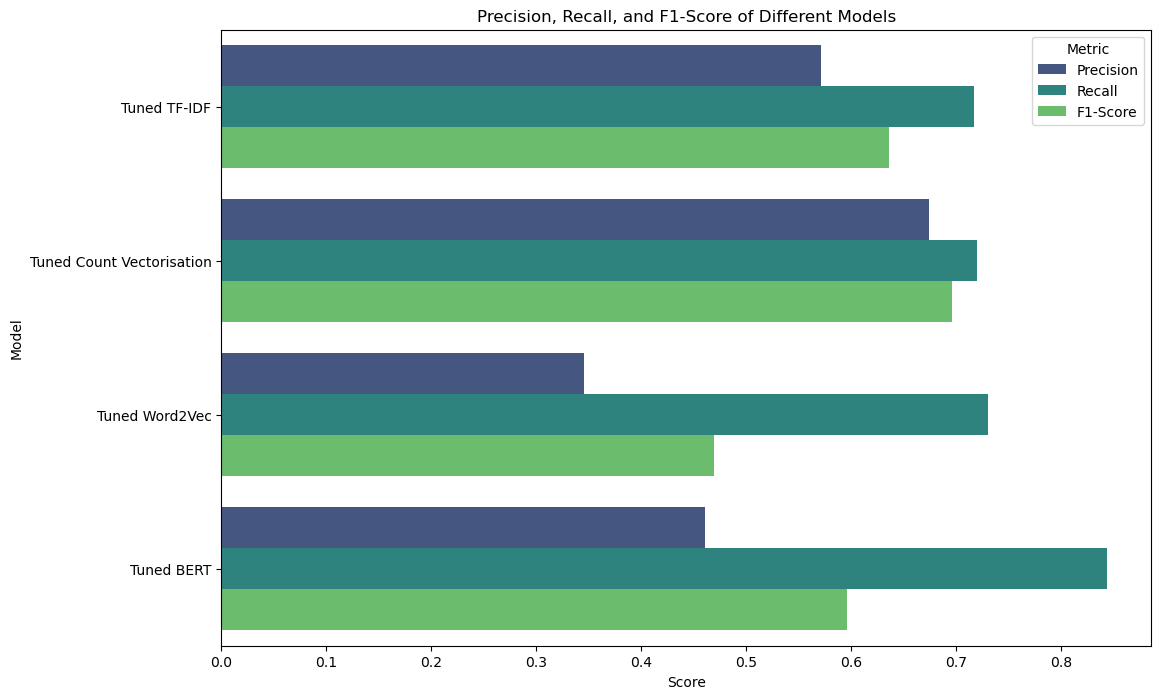

In [13]:
# Plotting Precision, Recall, and F1-Score for each model
metrics_df_melted = metrics_df_updated.melt(id_vars='Model', value_vars=['Precision', 'Recall', 'F1-Score'])

plt.figure(figsize=(12, 8))
sns.barplot(x='value', y='Model', hue='variable', data=metrics_df_melted, palette='viridis')
plt.xlabel('Score')
plt.ylabel('Model')
plt.title('Precision, Recall, and F1-Score of Different Models')
plt.legend(title='Metric')
plt.show()

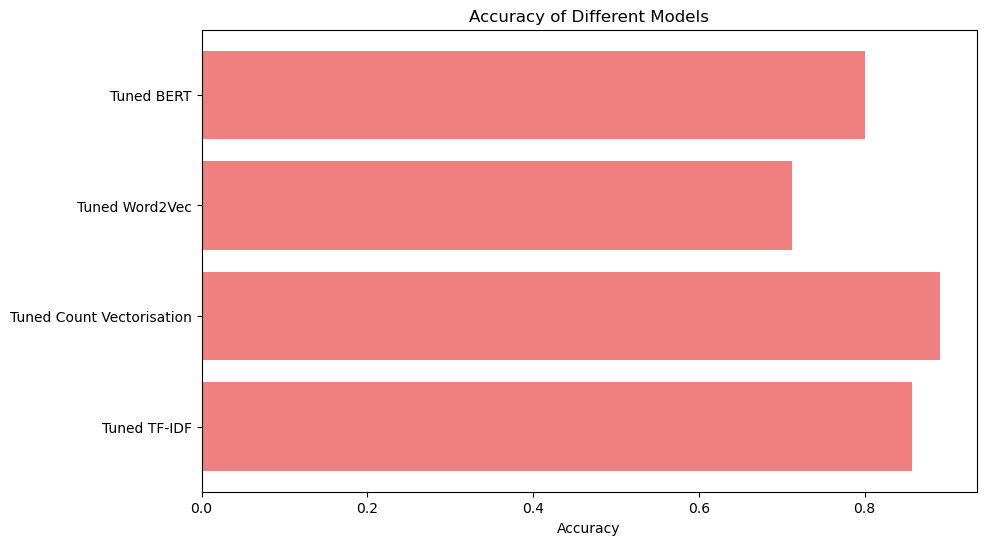

In [14]:
# Plotting Accuracy for each model
plt.figure(figsize=(10, 6))
plt.barh(metrics_df_updated['Model'], metrics_df_updated['Accuracy'], color='lightcoral')
plt.xlabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.show()

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step


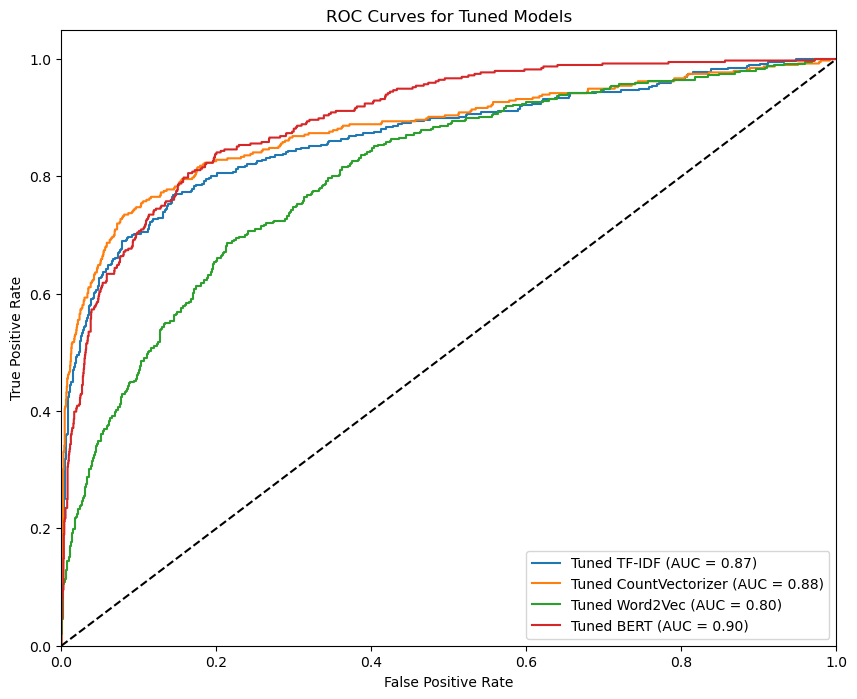

In [15]:
from sklearn.metrics import roc_curve, auc

# Function to plot ROC Curve
def plot_roc_curve(model, X_test, y_test, model_name):
    y_pred_prob = model.predict(X_test).ravel()
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plotting ROC curves for all models
plt.figure(figsize=(10, 8))

plot_roc_curve(model_tfidf_tuned, X_test_tfidf.toarray(), y_test, 'Tuned TF-IDF')
plot_roc_curve(model_count_tuned, X_test_count.toarray(), y_test, 'Tuned CountVectorizer')
plot_roc_curve(model_word2vec_tuned, X_test_word2vec, y_test, 'Tuned Word2Vec')
plot_roc_curve(model_bert_tuned, X_test_bert, y_test, 'Tuned BERT')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Tuned Models')
plt.legend(loc='lower right')
plt.show()

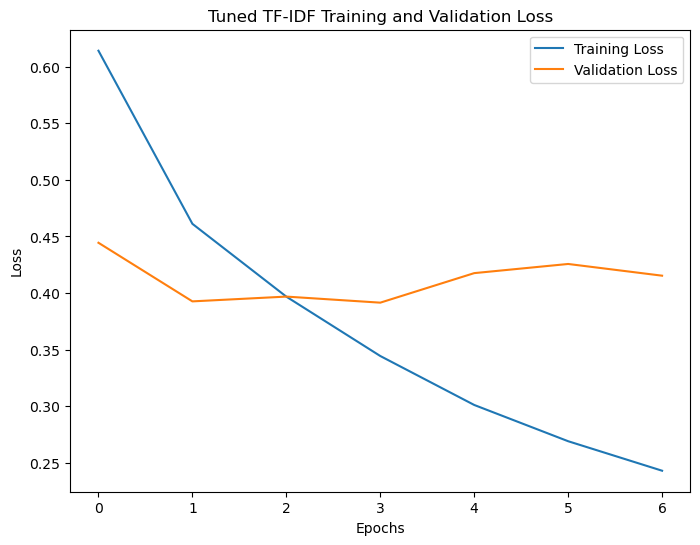

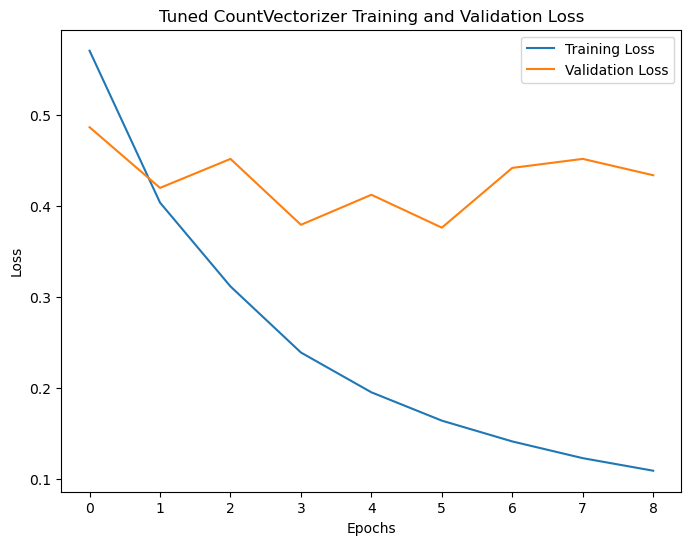

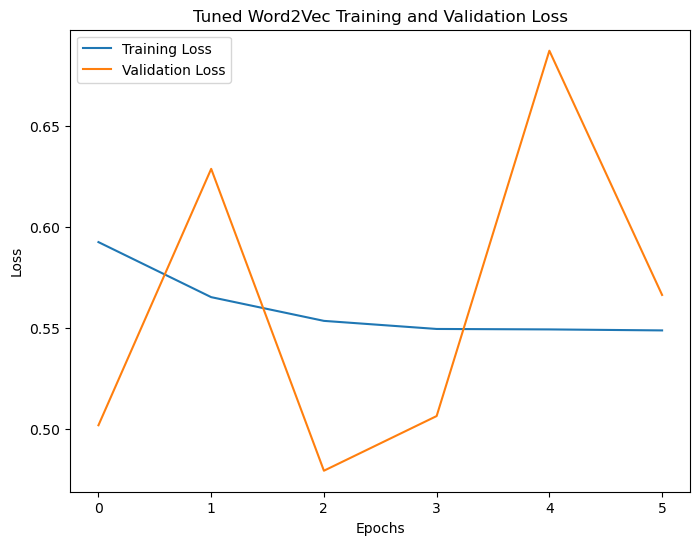

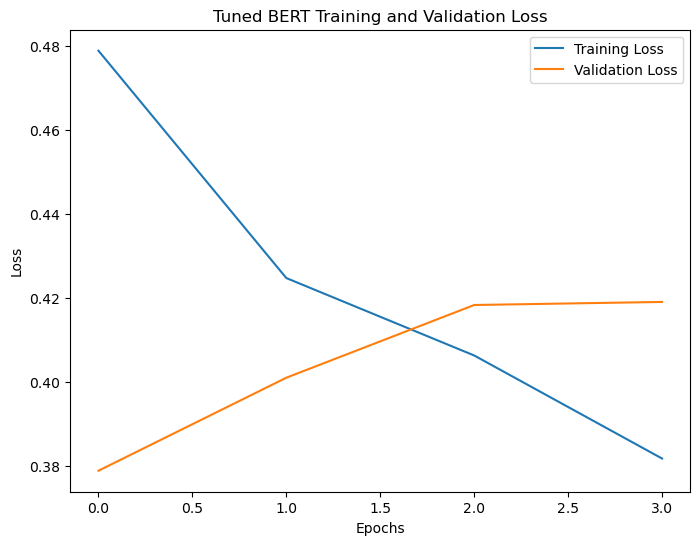

In [16]:
# Plotting the validation loss for each model

def plot_loss(history, model_name):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history_tfidf, 'Tuned TF-IDF')
plot_loss(history_count, 'Tuned CountVectorizer')
plot_loss(history_word2vec, 'Tuned Word2Vec')
plot_loss(history_bert, 'Tuned BERT')

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


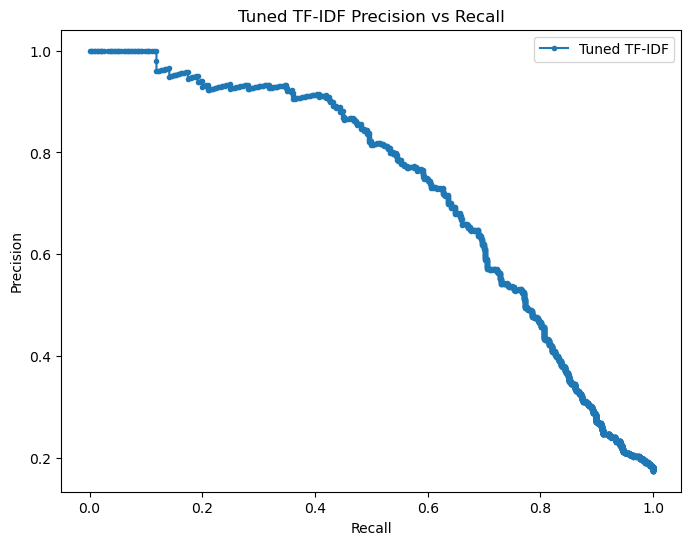

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


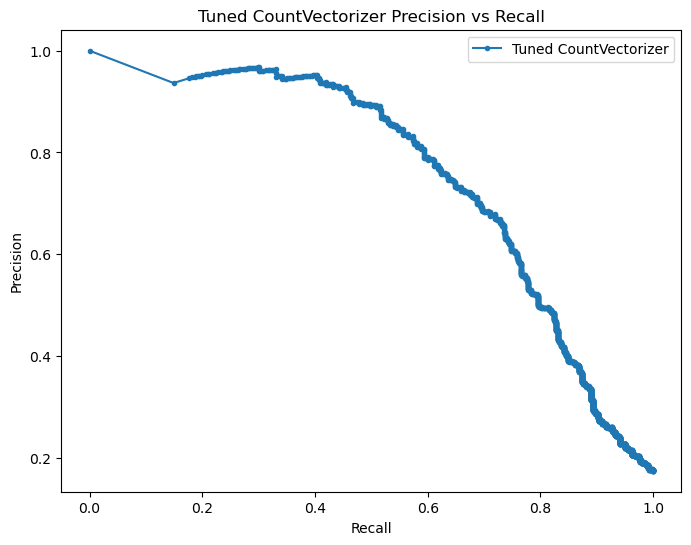

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step


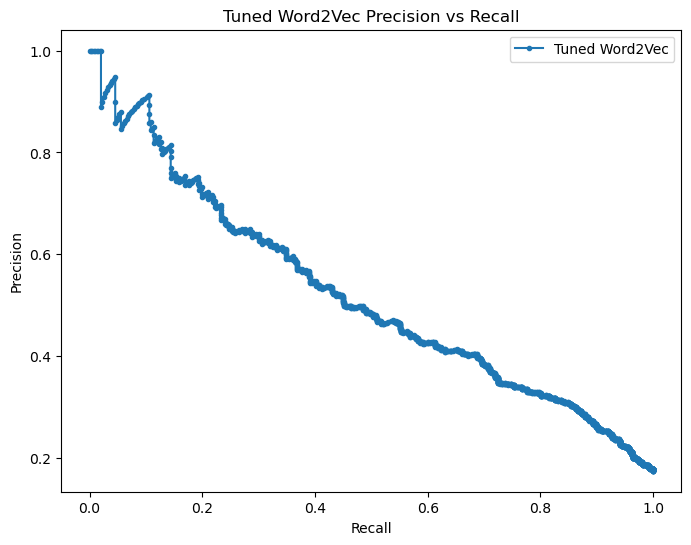

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step


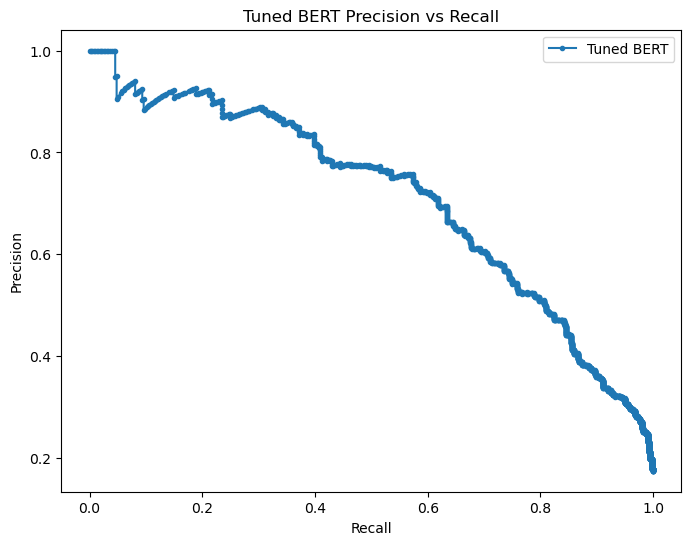

In [17]:
from sklearn.metrics import precision_recall_curve

# Plotting Precision-Recall curve for each model
def plot_precision_recall(model, X_test, y_test, model_name):
    y_pred_prob = model.predict(X_test).ravel()
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label=model_name)
    plt.title(f'{model_name} Precision vs Recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

plot_precision_recall(model_tfidf_tuned, X_test_tfidf.toarray(), y_test, 'Tuned TF-IDF')
plot_precision_recall(model_count_tuned, X_test_count.toarray(), y_test, 'Tuned CountVectorizer')
plot_precision_recall(model_word2vec_tuned, X_test_word2vec, y_test, 'Tuned Word2Vec')
plot_precision_recall(model_bert_tuned, X_test_bert, y_test, 'Tuned BERT')

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


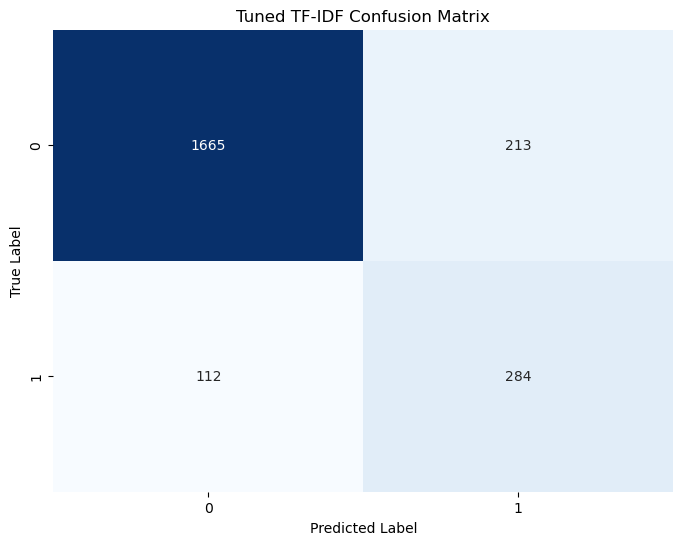

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


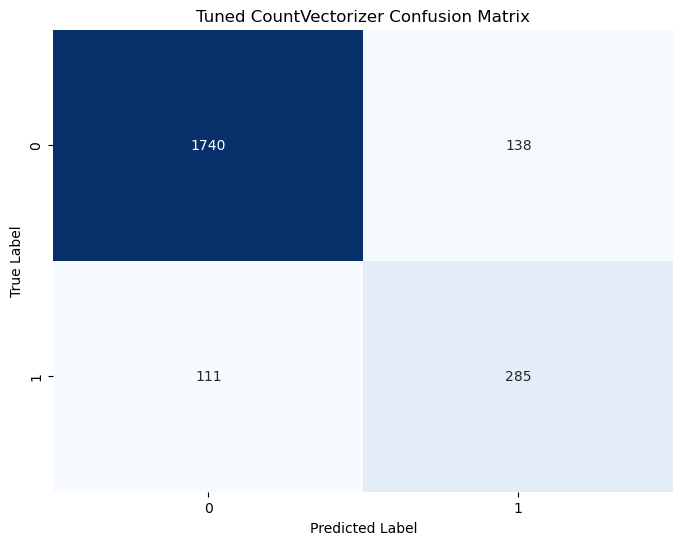

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step


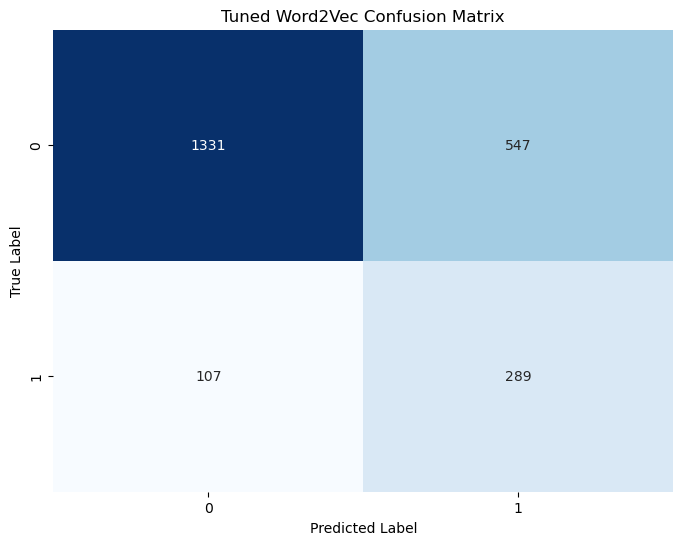

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step


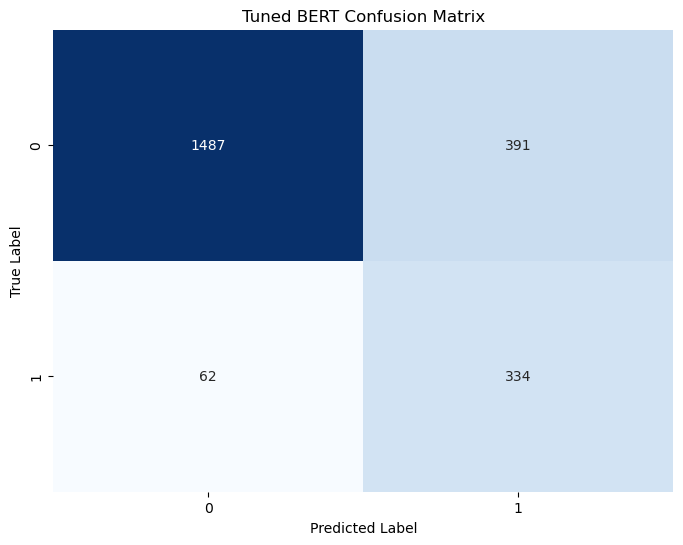

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plotting the confusion matrix for each model
def plot_confusion_matrix(model, X_test, y_test, model_name):
    y_pred_prob = model.predict(X_test).ravel()
    y_pred = (y_pred_prob > 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_confusion_matrix(model_tfidf_tuned, X_test_tfidf.toarray(), y_test, 'Tuned TF-IDF')
plot_confusion_matrix(model_count_tuned, X_test_count.toarray(), y_test, 'Tuned CountVectorizer')
plot_confusion_matrix(model_word2vec_tuned, X_test_word2vec, y_test, 'Tuned Word2Vec')
plot_confusion_matrix(model_bert_tuned, X_test_bert, y_test, 'Tuned BERT')

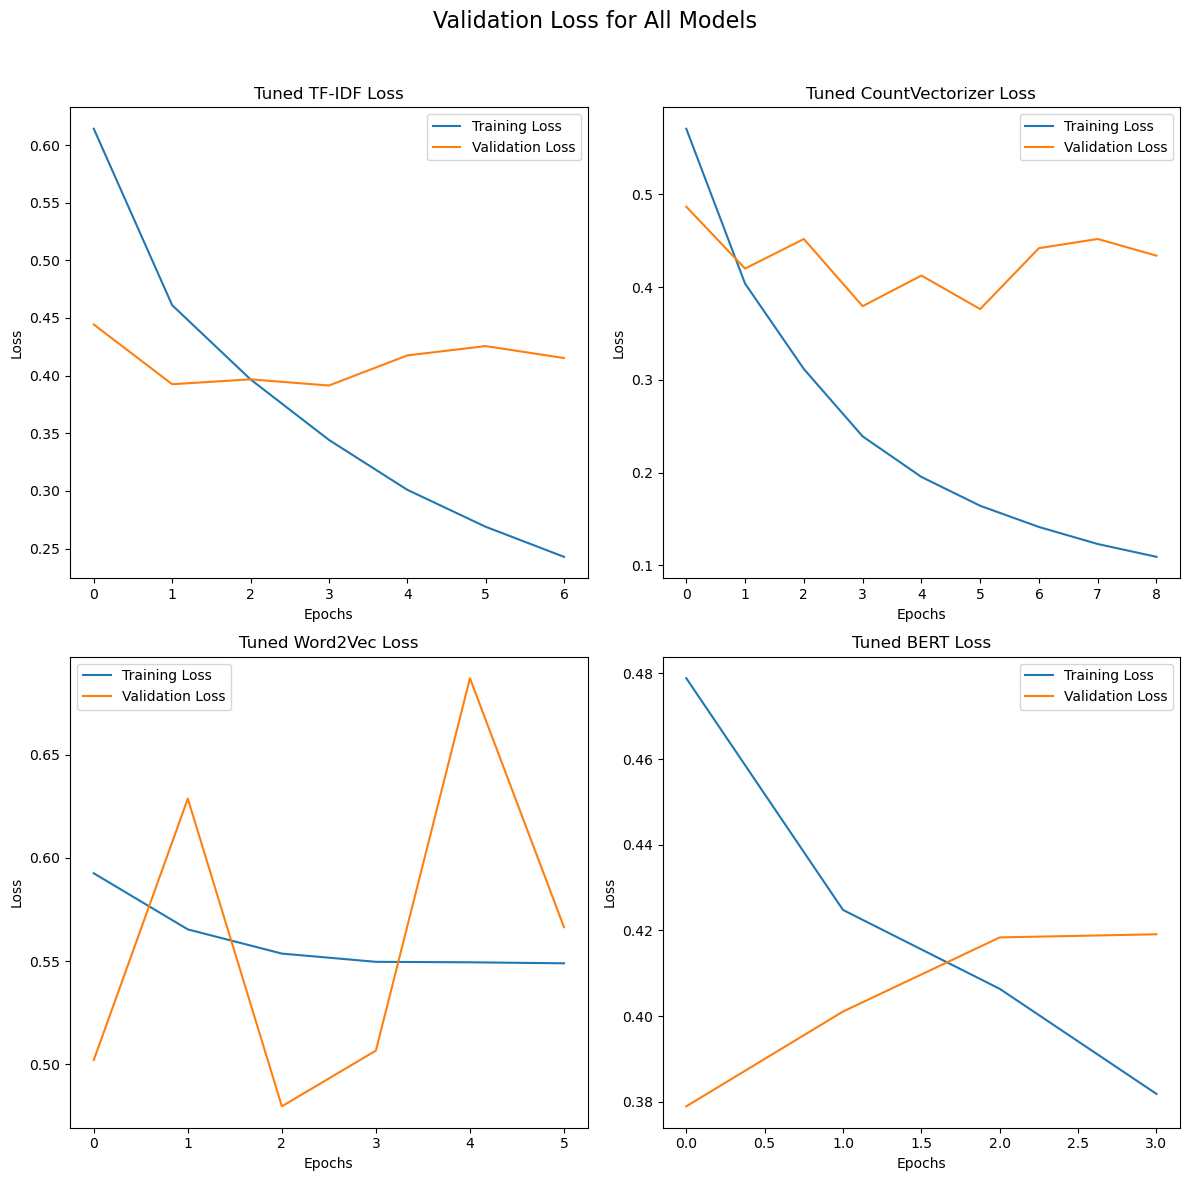

In [27]:
# Plotting the validation loss for all models in a 4x4 grid
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle('Validation Loss for All Models', fontsize=16)

plot_loss(history_tfidf, 'Tuned TF-IDF', axs[0, 0])
plot_loss(history_count, 'Tuned CountVectorizer', axs[0, 1])
plot_loss(history_word2vec, 'Tuned Word2Vec', axs[1, 0])
plot_loss(history_bert, 'Tuned BERT', axs[1, 1])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step


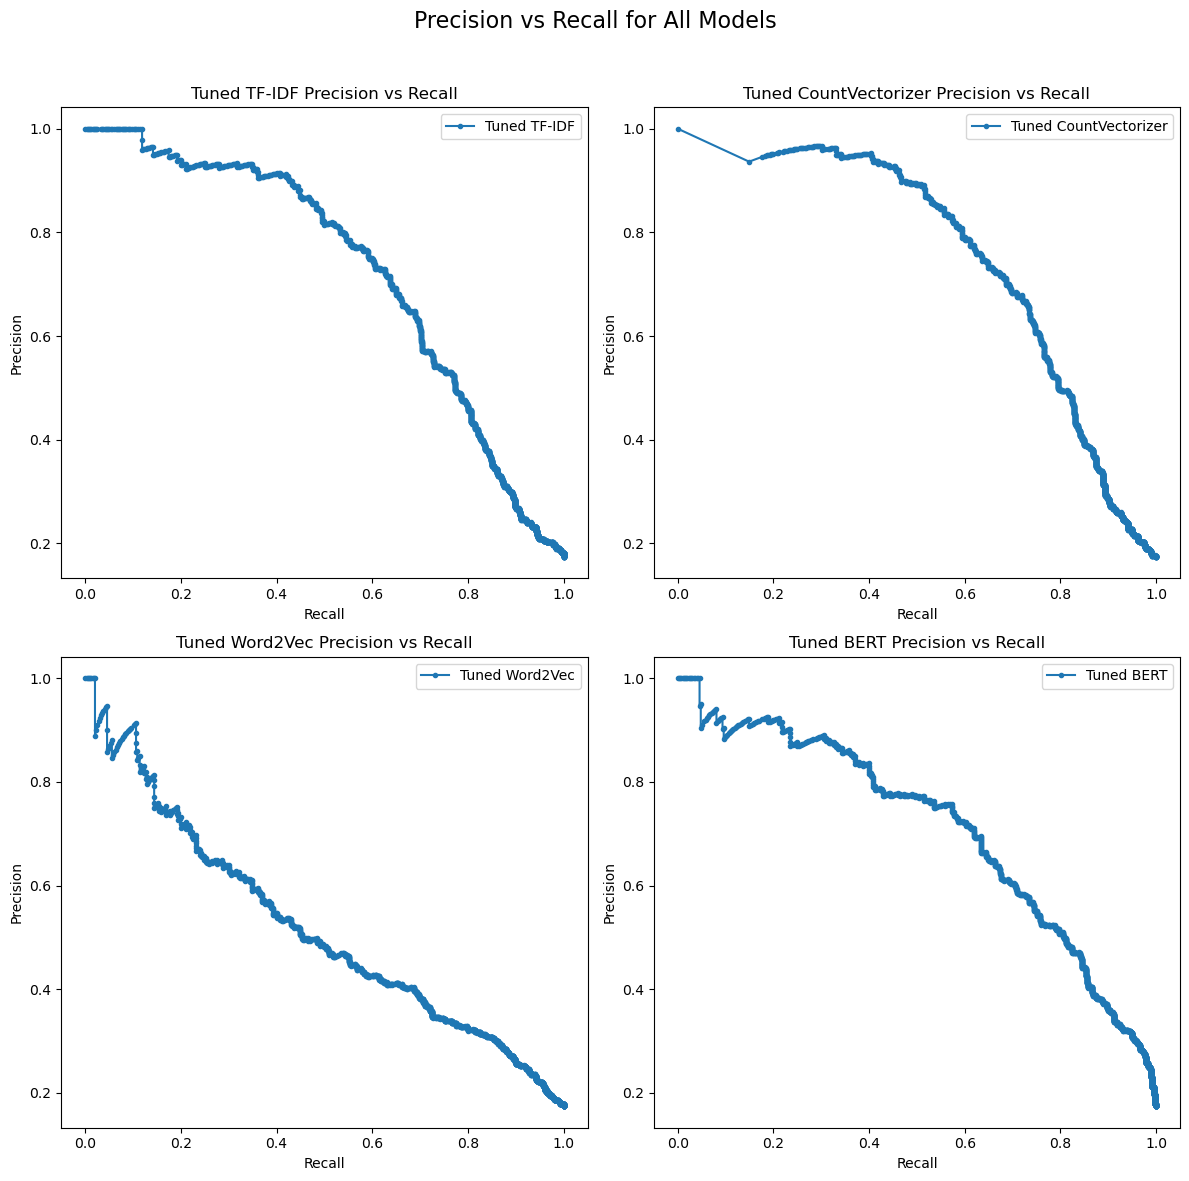

In [28]:
# Plotting Precision vs Recall for all models in a 4x4 grid
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle('Precision vs Recall for All Models', fontsize=16)

plot_precision_recall(model_tfidf_tuned, X_test_tfidf.toarray(), y_test, 'Tuned TF-IDF', axs[0, 0])
plot_precision_recall(model_count_tuned, X_test_count.toarray(), y_test, 'Tuned CountVectorizer', axs[0, 1])
plot_precision_recall(model_word2vec_tuned, X_test_word2vec, y_test, 'Tuned Word2Vec', axs[1, 0])
plot_precision_recall(model_bert_tuned, X_test_bert, y_test, 'Tuned BERT', axs[1, 1])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step


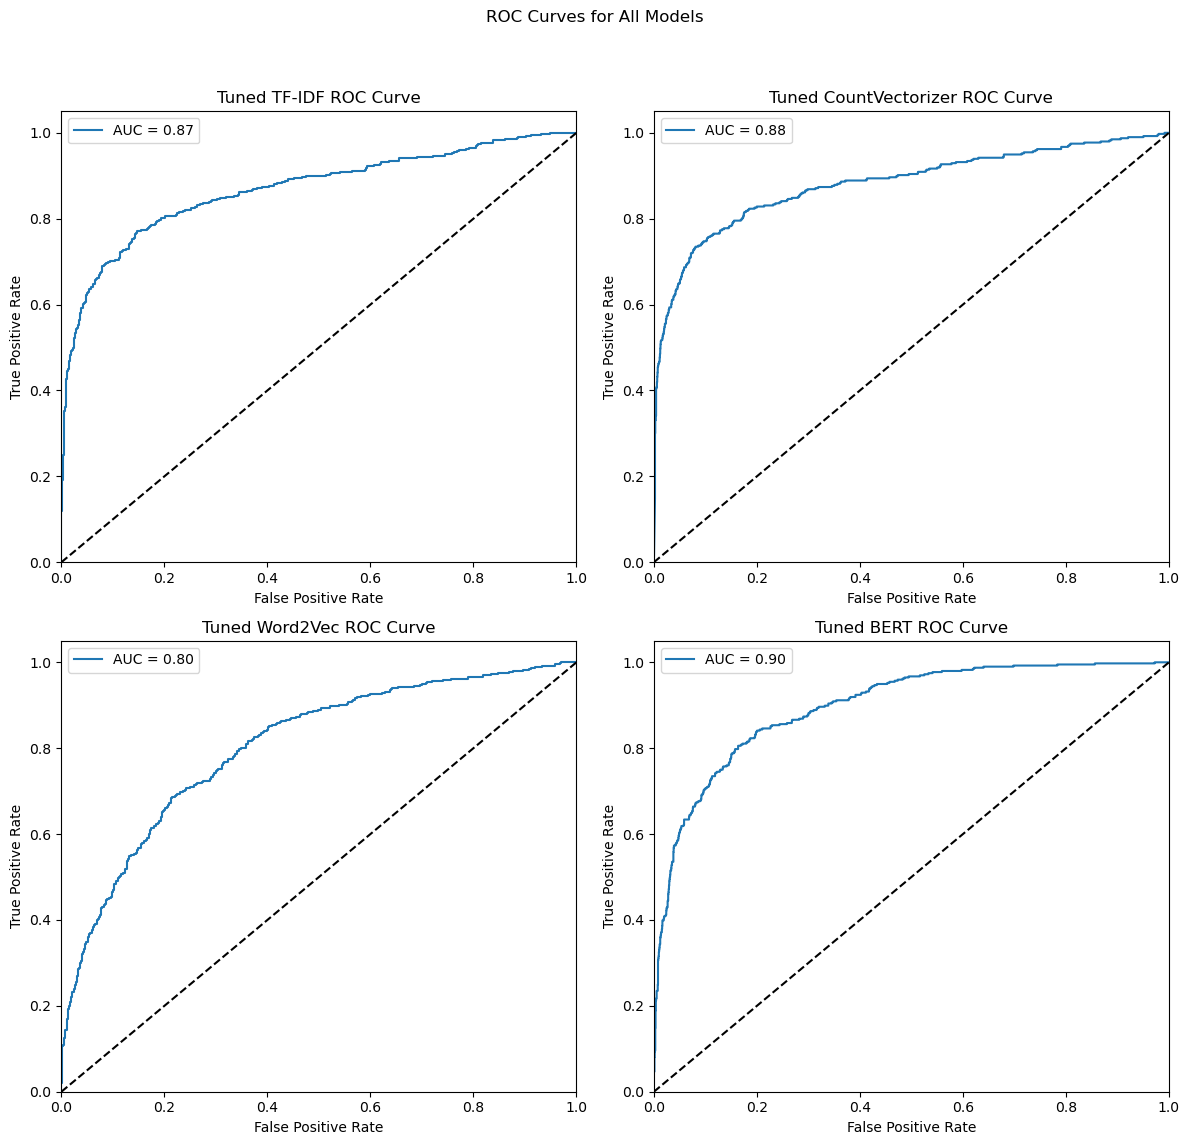

In [30]:
# Create subplots for ROC curves
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle('ROC Curves for All Models')

plot_roc_curve(model_tfidf_tuned, X_test_tfidf.toarray(), y_test, 'Tuned TF-IDF', axs[0, 0])
plot_roc_curve(model_count_tuned, X_test_count.toarray(), y_test, 'Tuned CountVectorizer', axs[0, 1])
plot_roc_curve(model_word2vec_tuned, X_test_word2vec, y_test, 'Tuned Word2Vec', axs[1, 0])
plot_roc_curve(model_bert_tuned, X_test_bert, y_test, 'Tuned BERT', axs[1, 1])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the title
plt.show()

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step


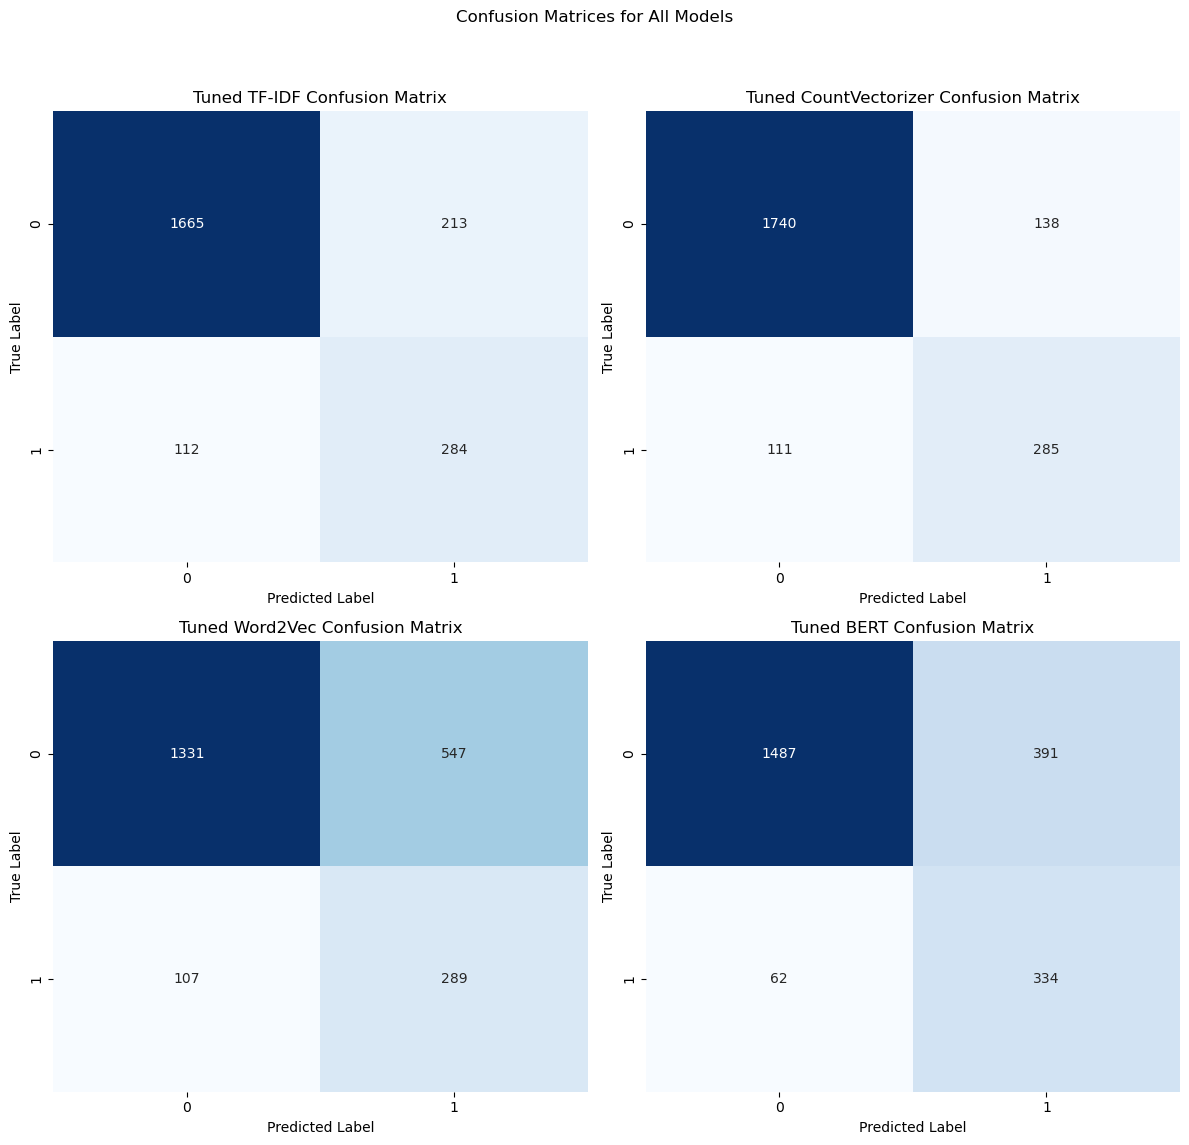

In [31]:
# Create subplots for Confusion Matrices
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle('Confusion Matrices for All Models')

plot_confusion_matrix(model_tfidf_tuned, X_test_tfidf.toarray(), y_test, 'Tuned TF-IDF', axs[0, 0])
plot_confusion_matrix(model_count_tuned, X_test_count.toarray(), y_test, 'Tuned CountVectorizer', axs[0, 1])
plot_confusion_matrix(model_word2vec_tuned, X_test_word2vec, y_test, 'Tuned Word2Vec', axs[1, 0])
plot_confusion_matrix(model_bert_tuned, X_test_bert, y_test, 'Tuned BERT', axs[1, 1])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the title
plt.show()

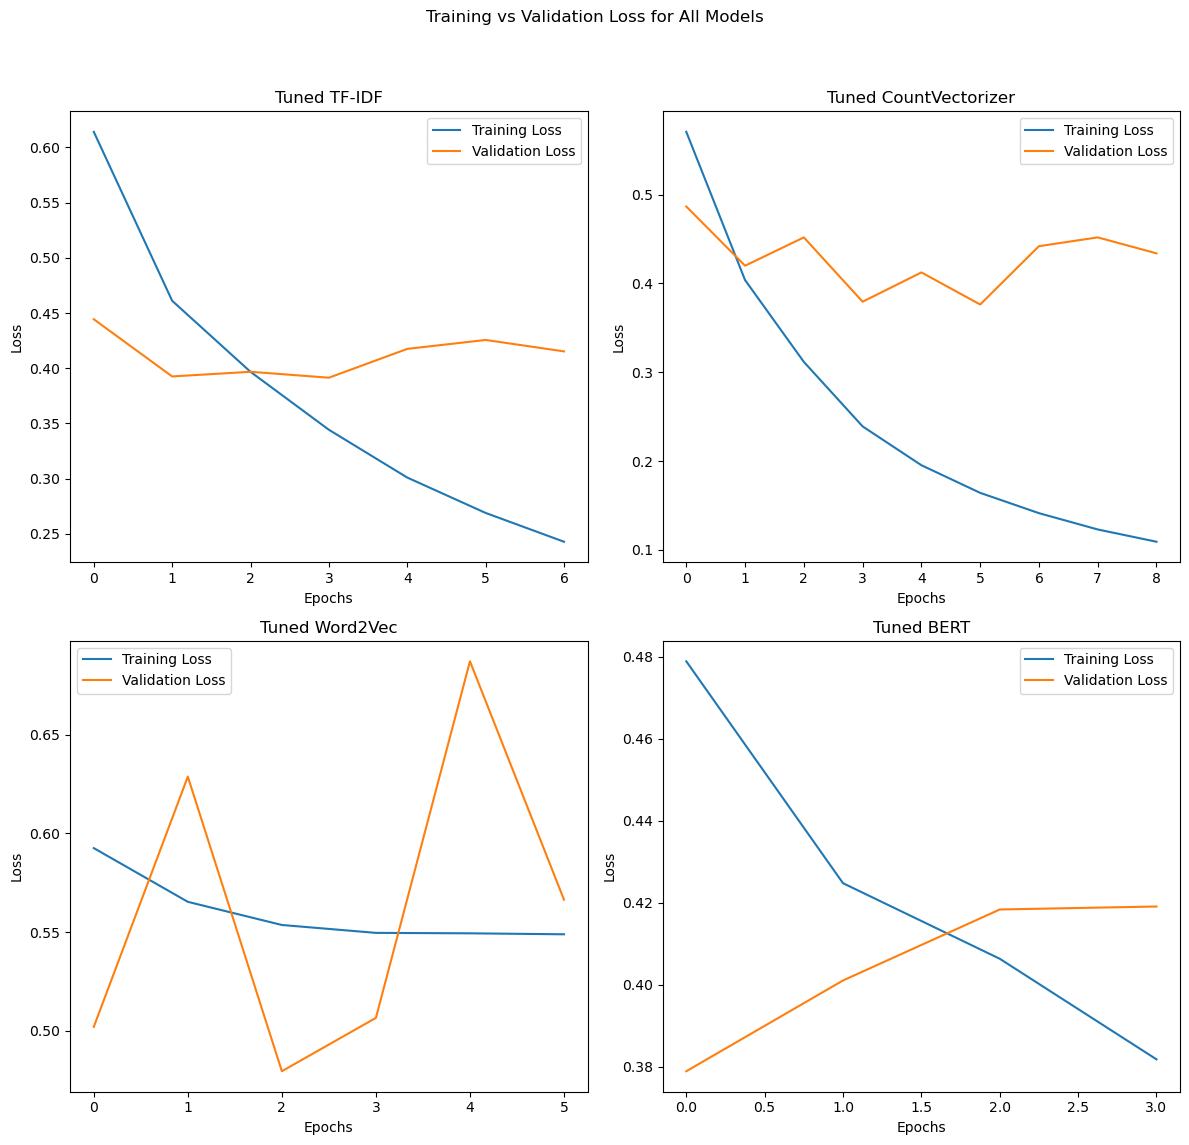

In [32]:
# Function to plot training vs validation loss
def plot_training_vs_validation_loss(history, model_name, ax):
    ax.plot(history.history['loss'], label='Training Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    ax.set_title(f'{model_name}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

# Create subplots for training vs validation loss
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle('Training vs Validation Loss for All Models')

plot_training_vs_validation_loss(history_tfidf, 'Tuned TF-IDF', axs[0, 0])
plot_training_vs_validation_loss(history_count, 'Tuned CountVectorizer', axs[0, 1])
plot_training_vs_validation_loss(history_word2vec, 'Tuned Word2Vec', axs[1, 0])
plot_training_vs_validation_loss(history_bert, 'Tuned BERT', axs[1, 1])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title
plt.show()